## Import

In [1]:
import uproot as up
from cycler import cycler
import mplhep as hep
import matplotlib.pyplot as plt
import numpy as np
import os
import hist

## Define common variables

In [2]:
processes = ['genbb', 'genb', 'gencc', 'genc',  'genother']

processNames = {
    'genb': 'b',
    'genbb': r'$b\bar{b}$',
    'genc': 'c',
    'gencc': r'$c\bar{c}$',
    'genother': 'light flavor',
}

colorDict = {
    'genbb': '#99ffff',
    'genb': '#ccccff',
    'gencc': '#ffccff',
    'genc': '#ffff99',
    'genother': '#ff9999',
}

## Define useful function

In [11]:
def plot_postfit(f, year, category, processes, saveplot=False):
    
    fig, (ax, rax) = plt.subplots(2, 1, figsize=(10,10), 
                                  gridspec_kw=dict(height_ratios=[3, 1], hspace=0.07), sharex=True)
    errps = {'hatch':'////', 'facecolor':'none', 'lw': 0, 'color': 'k', 'alpha': 0.3}
    ax.set_ylabel('Events/GeV', fontsize=15)
    ax._get_lines.prop_cycler = ax._get_patches_for_fill.prop_cycler
    args = {'linestyle':'--', 'linewidth': 5}
    ax.set_yscale('log')
    ax.set_ylim(1e-2, 5e+5)
    hep.cms.label(ax=ax, loc=0,label='Preliminary', lumi=lumi, year=year, fontsize=15)

    preidx = 'svmass'+year+category+'_prefit'
    postidx = 'svmass'+year+category+'_postfit'

    predir = f[preidx]
    postdir = f[postidx]
    edges = postdir['TotalBkg'].edges

    process_bin = []
    colors=[]
    mc_list = []

    sum_prefit = np.zeros(len(edges)-1)
    sum_postfit = np.zeros(len(edges)-1)
    sum_postfit_variance = np.zeros(len(edges)-1)

    for process in processes:
        prebin = predir[process].values
        postbin = postdir[process].values
        postfit_bin_variance = np.minimum(postbin, postdir[process].variances)
        process_bin.append(postbin)
        sum_prefit += prebin
        sum_postfit += postbin
        sum_postfit_variance += postfit_bin_variance
        colors.append(colorDict[process])
        mc_list.append(processNames[process])

    colors.reverse()
    ax.set_prop_cycle(cycler(color=colors))

    ### Call data ###
    data = postdir['data_obs'].values
    hep.histplot(data, edges, ax=ax, histtype='errorbar', label="Data", color='k')
    hep.histplot(sum_prefit, edges, ax=ax, label=["SM total (pre-fit)"], color='r', 
                 linestyle='dashed', linewidth=2)
    hep.histplot(sum_postfit, edges, ax=ax, label=["SM total (post-fit)"], color='b', linewidth=3)
    hep.histplot(process_bin, edges, ax=ax, stack=True, 
                     histtype='fill', edgecolor = 'k', linewidth=1, label=mc_list)

    y1 = sum_postfit - np.sqrt(sum_postfit_variance)
    y1 = np.append(y1, 0)
    y2 = sum_postfit + np.sqrt(sum_postfit_variance)
    y2 = np.append(y2, 0)
    ax.fill_between(
        x = edges,
        y1 = y1,
        y2 = y2,
        step = 'post',
        **errps, label='Unc.'
    )

    handles, labels = ax.get_legend_handles_labels()
    order = [8,0,1,2,3,4,5,6,7]
    ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
                loc='upper right', fontsize=12, ncol=2) 

    ### Drawing in ratio axes ###
    hep.histplot(data/sum_prefit, edges, yerr=np.sqrt(data)/sum_prefit, ax=rax, histtype='errorbar', 
                 color='r', capsize=4, label="Prefit")
    hep.histplot(data/sum_postfit, edges, yerr=np.sqrt(data)/sum_postfit, ax=rax, histtype='errorbar', 
                 color='b', capsize=4, label="Postfit")

    y1 = 1.- np.sqrt(sum_postfit_variance)/sum_postfit_variance
    y1 = np.append(y1, 0)
    y2 = 1.+ np.sqrt(sum_postfit_variance)/sum_postfit_variance
    y2 = np.append(y2, 0)

    rax.fill_between(
        x = edges,
        y1 = y1,
        y2 = y2,
        step='post',
       **errps, label='Bkg Uncs.'
    )

    rax.axhline(1, ls='--', color='k')
    rax.set_ylim(0.3, 1.6)
    rax.set_xlabel('log(m_{SV1,d_{xy}sigmax}/GeV)', fontsize=15)
    rax.set_ylabel('Obs/Exp', fontsize=15)#, loc='center')
    handles, labels = rax.get_legend_handles_labels()
    order = [1,2,0]
    rax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
               loc='upper right', fontsize=12, ncol=3) 
    
    os.system('mkdir -p ./plots/doublesf/postfit/'+year+'/')
    plot_path = os.path.abspath('./plots/doublesf/postfit/'+year+'/')
    plot_name = category+'_svmass.png'
    
    if saveplot:
        fig.savefig(os.path.join(plot_path, plot_name))

TypeError: _exp_label() got an unexpected keyword argument 'label'

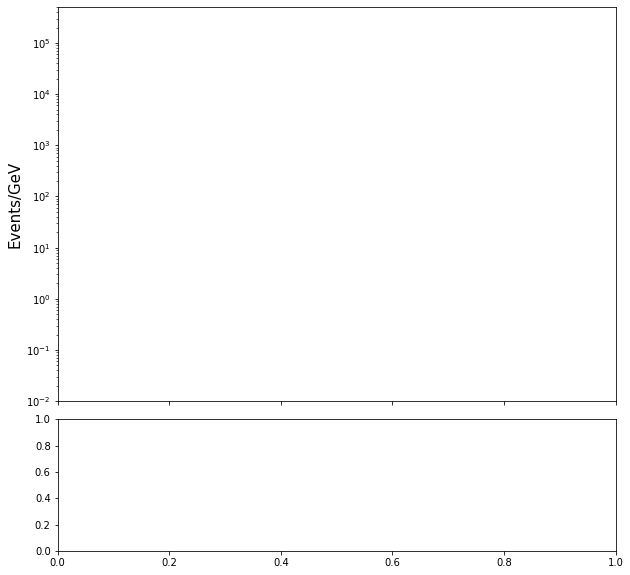

In [12]:
## year, category
year = '2018'
category = 'pass'
lumis = { #Values from https://twiki.cern.ch/twiki/bin/viewauth/CMS/PdmVAnalysisSummaryTable                                                      
        '2016': "35.92",
        '2017': "41.53",
        '2018': "59.74"
    }
lumi=lumis[year]
saveplot = False
f = up.open("../hists/doublebsf.postfit")

plot_postfit(f, year, category, processes, saveplot)